In [11]:
%cd ~/project/kuzushiji-vision-lightning

import os

print("Current working directory:", os.getcwd())


/home/ryo/project/kuzushiji-vision-lightning
Current working directory: /home/ryo/project/kuzushiji-vision-lightning


In [12]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import yaml
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

# GPUが利用可能な場合は使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [13]:
# 実験ディレクトリの設定（学習完了後に適切なパスに変更してください）
# 例: "experiments/character_detection/20250101_120000"
experiment_dir = "experiments/character_detection/yolo11l"  # 実際の学習結果ディレクトリに変更
model_path = os.path.join(experiment_dir, "weights/best.pt")
config_path = os.path.join(experiment_dir, "config.yaml")

# 設定ファイルの読み込み
def load_yaml(path):
    with open(path, encoding="utf-8") as f:
        return yaml.safe_load(f)

# 学習済みモデルの確認
if os.path.exists(model_path):
    print(f"Model found: {model_path}")
    if os.path.exists(config_path):
        config = load_yaml(config_path)
        print("Configuration loaded successfully")
    else:
        print(f"Warning: Config file not found at {config_path}")
        config = {}
else:
    print(f"Warning: Model file not found at {model_path}")
    print("Please update experiment_dir with the correct path after training is complete.")


Model found: experiments/character_detection/yolo11l/weights/best.pt
Configuration loaded successfully


In [14]:
# テストデータのパス設定
test_images_dir = "data/yolo_dataset_character_detection/test/images"
test_labels_dir = "data/yolo_dataset_character_detection/test/labels"

def load_yolo_labels(label_path):
    """YOLOラベルファイルを読み込む
    
    Args:
        label_path (str): ラベルファイルのパス
        
    Returns:
        list: [class_id, x_center, y_center, width, height] のリスト
    """
    labels = []
    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    labels.append([class_id, x_center, y_center, width, height])
    except FileNotFoundError:
        print(f"Warning: Label file not found: {label_path}")
    return labels

def yolo_to_xyxy(box, img_width, img_height):
    """YOLO形式（正規化済み）からxyxy形式に変換
    
    Args:
        box: [class_id, x_center, y_center, width, height]
        img_width: 画像幅
        img_height: 画像高さ
        
    Returns:
        list: [x1, y1, x2, y2]
    """
    class_id, x_center, y_center, width, height = box
    
    # 正規化座標を実座標に変換
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    
    # 中心座標と幅高さから左上右下座標に変換
    x1 = x_center - width / 2
    y1 = y_center - height / 2
    x2 = x_center + width / 2
    y2 = y_center + height / 2
    
    return [x1, y1, x2, y2]

# テスト画像とラベルの対応を作成
test_data = []
image_files = glob.glob(os.path.join(test_images_dir, "*.jpg")) + glob.glob(os.path.join(test_images_dir, "*.png"))

print(f"Found {len(image_files)} test images")

for image_path in image_files:
    image_name = os.path.basename(image_path)
    label_name = os.path.splitext(image_name)[0] + ".txt"
    label_path = os.path.join(test_labels_dir, label_name)
    
    if os.path.exists(label_path):
        test_data.append({
            'image_path': image_path,
            'label_path': label_path,
            'image_name': image_name
        })

print(f"Found {len(test_data)} image-label pairs")


Found 713 test images
Found 713 image-label pairs


In [15]:
# YOLOモデルの読み込み
from ultralytics import YOLO

# 学習済みモデルの読み込み
try:
    if os.path.exists(model_path):
        model = YOLO(model_path)
        model.to(device)
        print(f"Model loaded successfully from {model_path}")
    else:
        print(f"Model file not found: {model_path}")
        print("Please ensure the model has been trained and the path is correct.")
        # デモンストレーション用にプリトレーニングモデルを使用（実際のテストでは削除）
        print("Loading pre-trained YOLOv8n model for demonstration...")
        model = YOLO('yolov8n.pt')
        model.to(device)
        print("Demo model loaded (replace with your trained model)")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None


Model loaded successfully from experiments/character_detection/yolo11l/weights/best.pt


In [16]:
def calculate_iou(box1, box2):
    """IoUを計算する
    
    Args:
        box1: [x1, y1, x2, y2]
        box2: [x1, y1, x2, y2]
        
    Returns:
        float: IoUスコア
    """
    # 交差領域の座標を計算
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # 交差領域の面積を計算
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # それぞれのボックスの面積を計算
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # IoUを計算
    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0

def evaluate_predictions(predictions, ground_truth, iou_threshold=0.5):
    """予測結果を評価する
    
    Args:
        predictions: 予測された矩形のリスト [[x1, y1, x2, y2, conf], ...]
        ground_truth: 正解の矩形のリスト [[x1, y1, x2, y2], ...]
        iou_threshold: IoUの閾値
        
    Returns:
        dict: 評価指標
    """
    true_positives = 0
    false_positives = 0
    false_negatives = len(ground_truth)
    
    # 各予測に対して最も近い正解を探す
    matched_gt = set()
    for pred in predictions:
        best_iou = 0 
        best_gt_idx = -1
        
        for i, gt in enumerate(ground_truth):
            if i in matched_gt:
                continue
                
            iou = calculate_iou(pred[:4], gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i
        
        if best_iou >= iou_threshold:
            true_positives += 1
            matched_gt.add(best_gt_idx)
            false_negatives -= 1
        else:
            false_positives += 1
    
    # 評価指標の計算
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }


In [17]:
# テスト画像に対して推論と評価を実行
results = []
metrics = []

if model is not None:
    # 限定的なテスト（最初の10枚の画像のみ）
    #test_subset = test_data[:10] if len(test_data) > 10 else test_data
    test_subset = test_data
    
    for data in tqdm(test_subset, desc="Testing"):
        image_path = data['image_path']
        label_path = data['label_path']
        image_name = data['image_name']
        
        # 画像の読み込み
        image = Image.open(image_path)
        img_width, img_height = image.size
        
        # グラウンドトゥルースの読み込み
        gt_labels = load_yolo_labels(label_path)
        gt_boxes = [yolo_to_xyxy(label, img_width, img_height) for label in gt_labels]
        
        # 推論実行
        with torch.no_grad():
            predictions = model(image_path)[0]
        
        # 予測結果の取得
        if hasattr(predictions, 'boxes') and predictions.boxes is not None:
            pred_boxes = predictions.boxes.data.cpu().numpy()
            # YOLOの出力形式: [x1, y1, x2, y2, confidence, class]
            pred_boxes_with_conf = pred_boxes.tolist()
        else:
            pred_boxes_with_conf = []
        
        # 評価
        metric = evaluate_predictions(pred_boxes_with_conf, gt_boxes)
        metrics.append(metric)
        
        # 結果を保存
        results.append({
            'image_name': image_name,
            'image_path': image_path,
            'image_size': (img_width, img_height),
            'predictions': pred_boxes_with_conf,
            'ground_truth': gt_boxes,
            'metrics': metric
        })
    
    # 全体の評価指標を計算
    if metrics:
        overall_metrics = {
            'precision': np.mean([m['precision'] for m in metrics]),
            'recall': np.mean([m['recall'] for m in metrics]),
            'f1': np.mean([m['f1'] for m in metrics])
        }
        
        print("\nOverall Metrics:")
        for k, v in overall_metrics.items():
            print(f"{k}: {v:.4f}")
    else:
        print("No results to evaluate")
else:
    print("Model is not loaded. Cannot perform evaluation.")


Testing:   0%|          | 0/713 [00:00<?, ?it/s]


image 1/1 /home/ryo/project/kuzushiji-vision-lightning/data/yolo_dataset_character_detection/test/images/100249537_100249537_00003_2.jpg: 640x416 82 items, 33.4ms
Speed: 2.9ms preprocess, 33.4ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/ryo/project/kuzushiji-vision-lightning/data/yolo_dataset_character_detection/test/images/200014685_200014685_00002_2.jpg: 640x416 128 items, 8.5ms
Speed: 3.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/ryo/project/kuzushiji-vision-lightning/data/yolo_dataset_character_detection/test/images/200015843_200015843_00064_1.jpg: 640x448 300 items, 31.4ms
Speed: 2.0ms preprocess, 31.4ms inference, 11.4ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/ryo/project/kuzushiji-vision-lightning/data/yolo_dataset_character_detection/test/images/100249537_100249537_00018_2.jpg: 640x416 94 items, 14.0ms
Speed: 1.3ms preprocess, 14.0ms inference, 11.6ms p

Best Case:


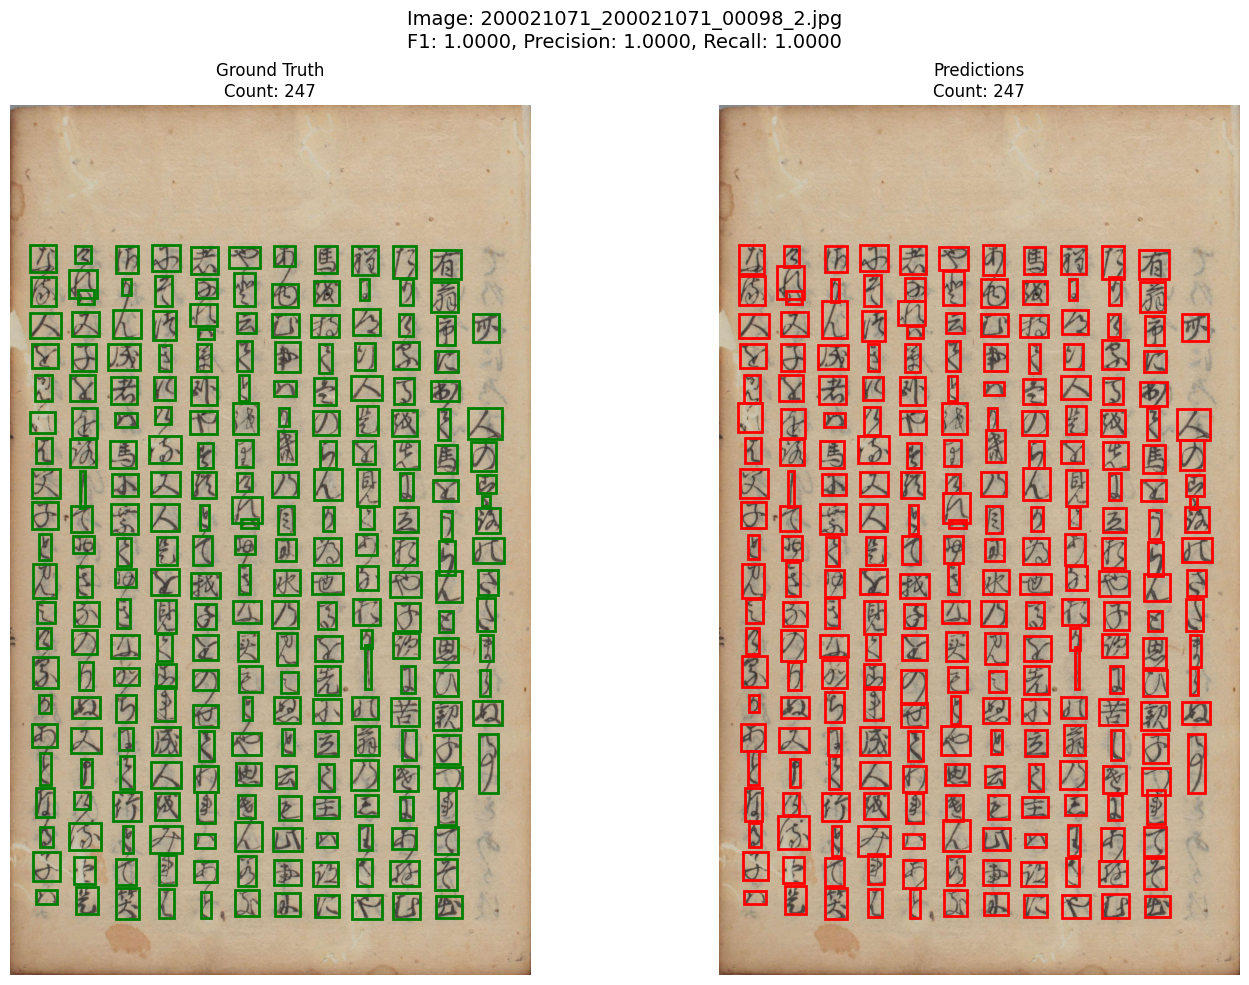

\nWorst Case:


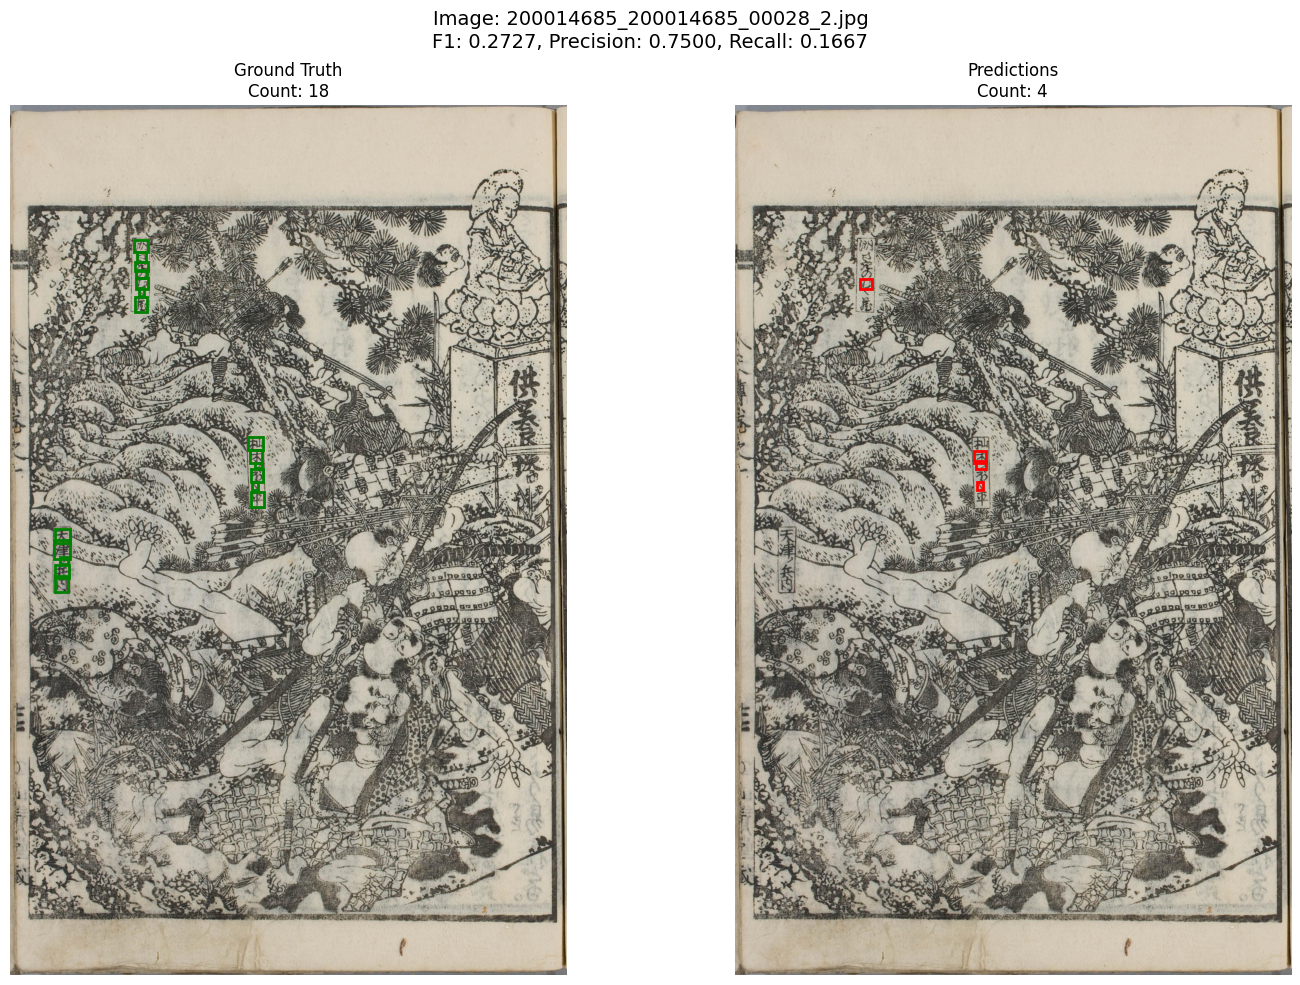

\nRandom Cases:
\nRandom Case 1:


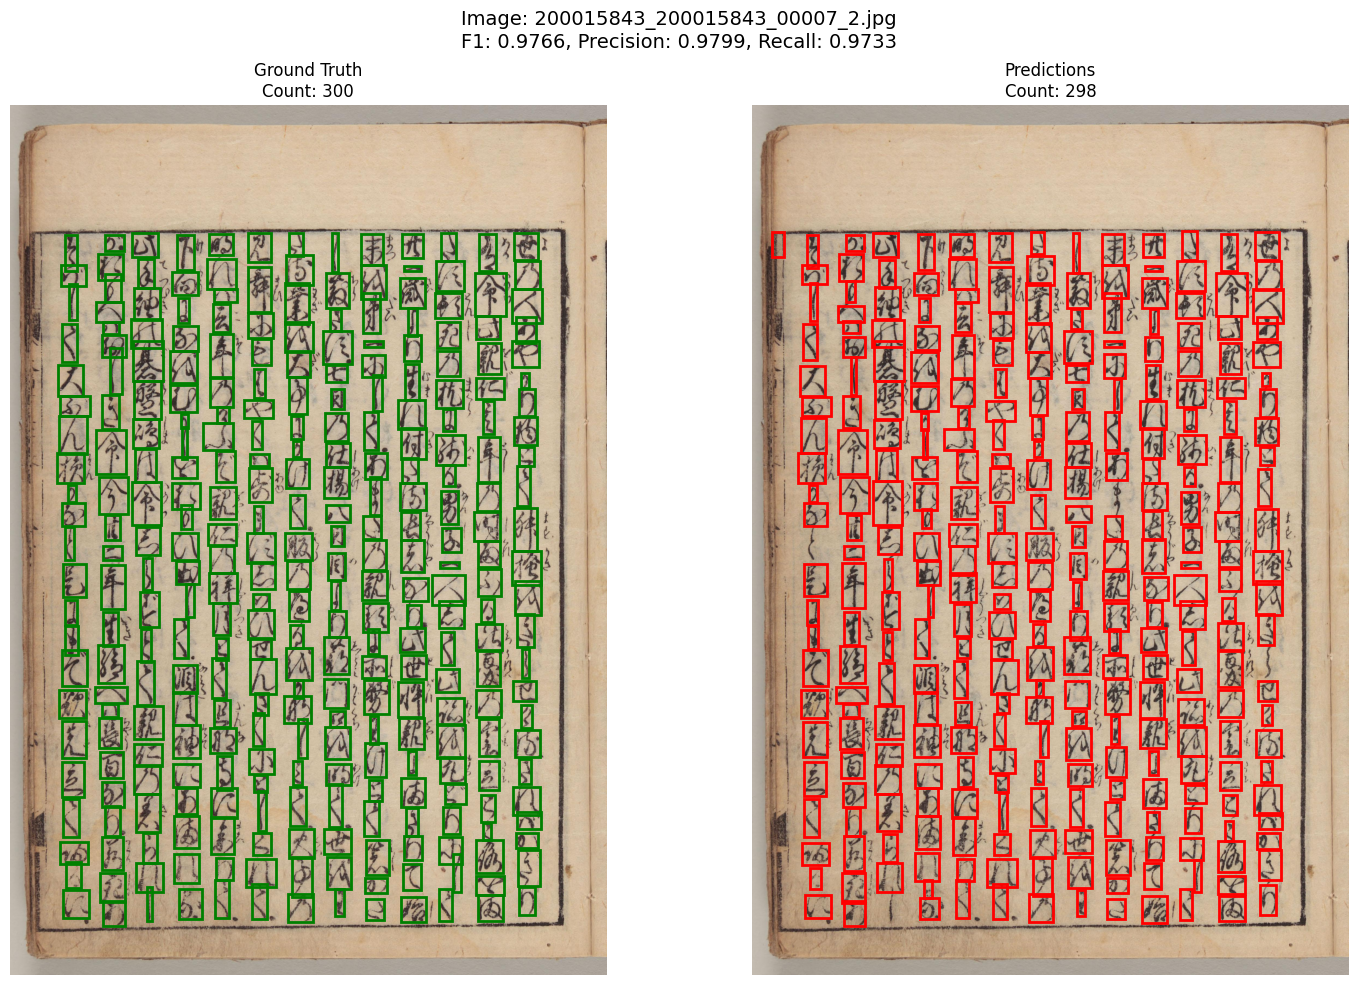

\nRandom Case 2:


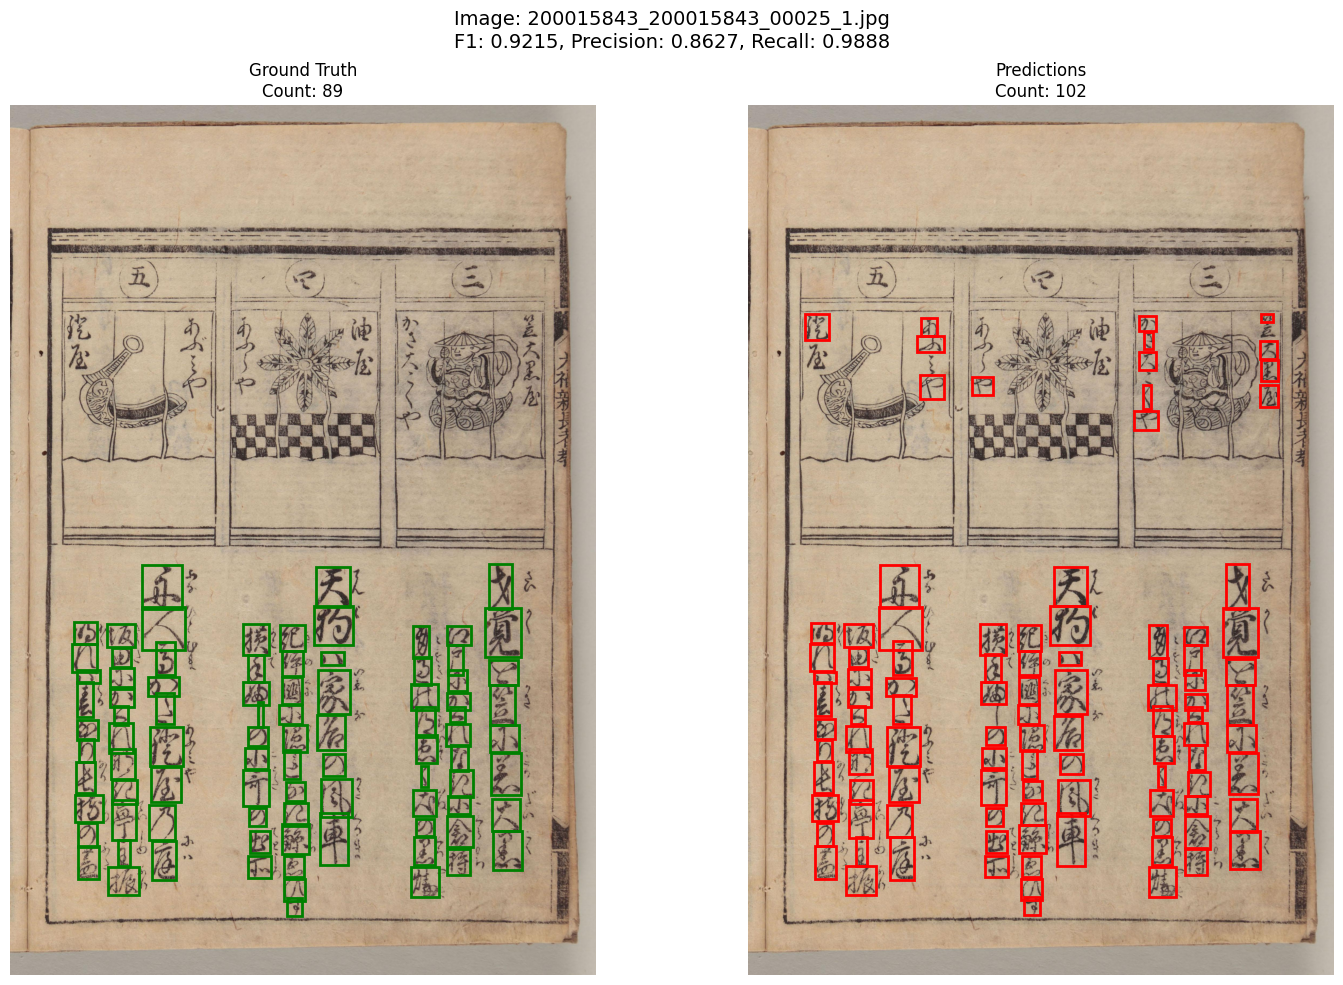

\nRandom Case 3:


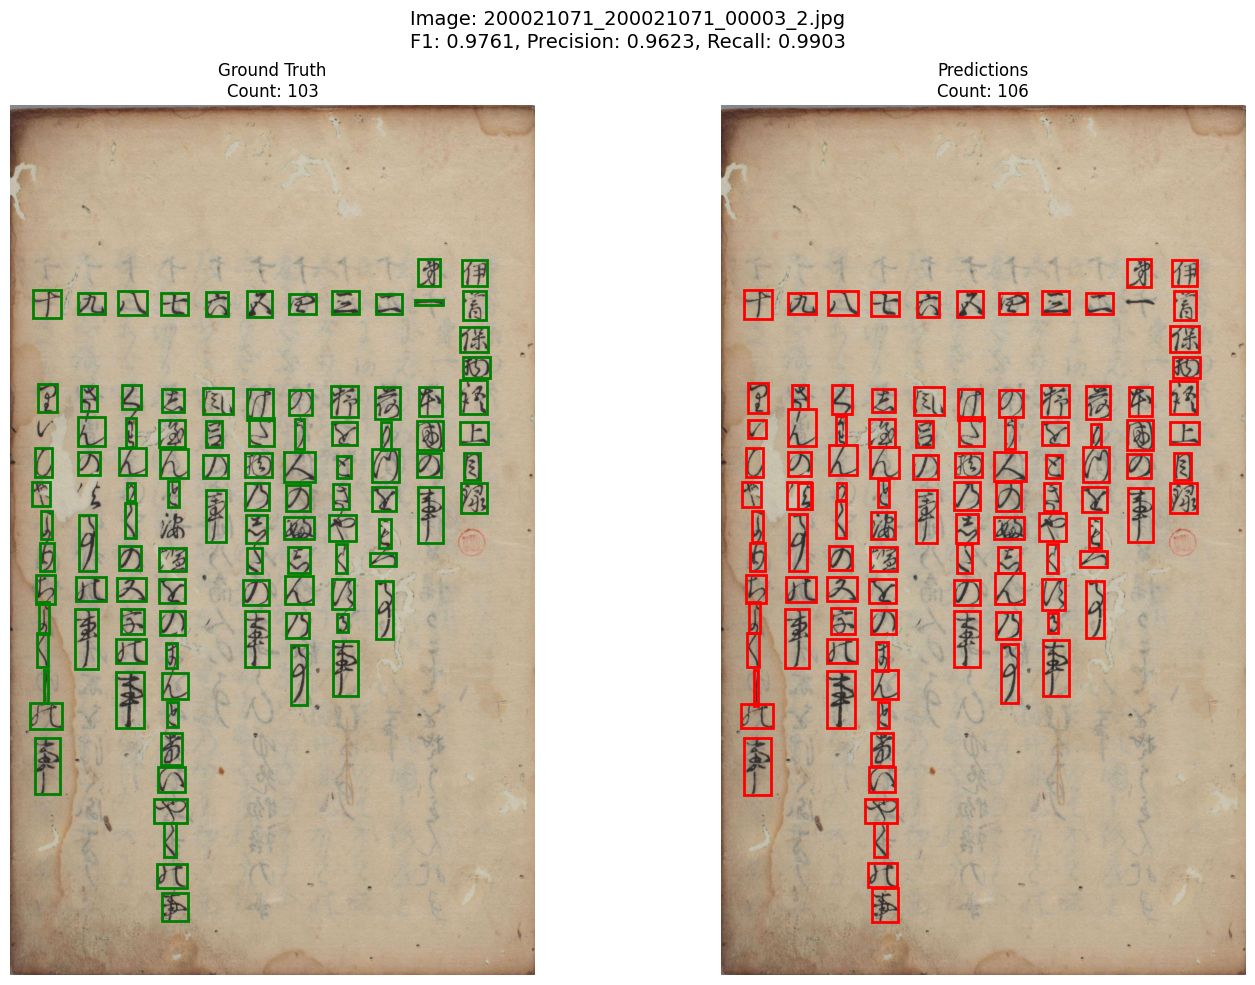

In [18]:
def visualize_results(result, figsize=(15, 10)):
    """検出結果を可視化する
    
    Args:
        result: 結果辞書
        figsize: 図のサイズ
    """
    image = Image.open(result['image_path'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 左側: Ground Truth
    ax1.imshow(image)
    for box in result['ground_truth']:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                               linewidth=2, edgecolor='green', facecolor='none')
        ax1.add_patch(rect)
    
    ax1.set_title(f"Ground Truth\nCount: {len(result['ground_truth'])}")
    ax1.axis('off')
    
    # 右側: Predictions
    ax2.imshow(image)
    for box in result['predictions']:
        if len(box) >= 5:  # [x1, y1, x2, y2, conf, class]
            x1, y1, x2, y2, conf = box[:5]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                   linewidth=2, edgecolor='red', facecolor='none')
            ax2.add_patch(rect)
            # ax2.text(x1, y1 - 5, f'{conf:.2f}', color='red', fontsize=8, 
            #        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    ax2.set_title(f"Predictions\nCount: {len(result['predictions'])}")
    ax2.axis('off')
    
    # 全体のタイトル
    fig.suptitle(f"Image: {result['image_name']}\n"
                f"F1: {result['metrics']['f1']:.4f}, "
                f"Precision: {result['metrics']['precision']:.4f}, "
                f"Recall: {result['metrics']['recall']:.4f}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

# 結果の可視化（モデルが読み込まれ、結果がある場合のみ）
if results:
    # 最良と最悪のケースを可視化
    sorted_results = sorted(results, key=lambda x: x['metrics']['f1'], reverse=True)
    
    print("Best Case:")
    best_case = sorted_results[0]
    visualize_results(best_case)
    
    if len(sorted_results) > 1:
        print("\\nWorst Case:")
        worst_case = sorted_results[-1]
        visualize_results(worst_case)
    
    # いくつかのランダムなケースも表示
    import random
    if len(results) > 2:
        print("\\nRandom Cases:")
        random_cases = random.sample(results, min(3, len(results)))
        for i, case in enumerate(random_cases):
            print(f"\\nRandom Case {i+1}:")
            visualize_results(case)
else:
    print("No results to visualize. Please ensure the model is trained and loaded correctly.")


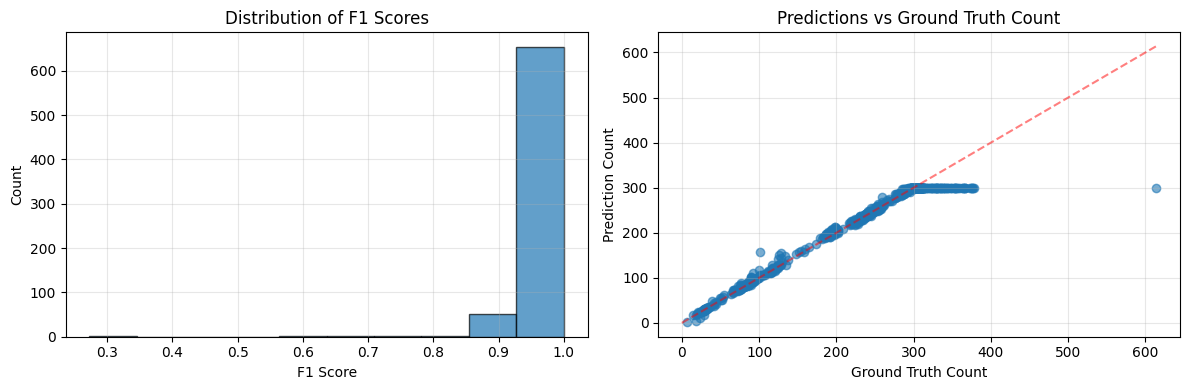


Performance Analysis:
Total test cases: 713
Good cases (F1 > 0.8): 707 (99.2%)
Difficult cases (F1 < 0.5): 2 (0.3%)
Average F1 score: 0.9636
Median F1 score: 0.9732
Standard deviation: 0.0490

Difficult Cases Analysis:

Image: 200014685_200014685_00016_2.jpg
  F1: 0.2857
  Predictions: 1, Ground Truth: 6
  Image size: (2058, 3241)
  TP: 1, FP: 0, FN: 5

Image: 200014685_200014685_00028_2.jpg
  F1: 0.2727
  Predictions: 4, Ground Truth: 18
  Image size: (2076, 3246)
  TP: 3, FP: 1, FN: 15

Detailed Statistics:
Precision - Mean: 0.9675, Std: 0.0337
Recall - Mean: 0.9631, Std: 0.0638
F1 - Mean: 0.9636, Std: 0.0490


In [19]:
# エラー分析とパフォーマンス統計
if results:
    # F1スコアの分布を可視化
    f1_scores = [r['metrics']['f1'] for r in results]
    
    plt.figure(figsize=(12, 4))
    
    # F1スコアのヒストグラム
    plt.subplot(1, 2, 1)
    plt.hist(f1_scores, bins=10, alpha=0.7, edgecolor='black')
    plt.title('Distribution of F1 Scores')
    plt.xlabel('F1 Score')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    # 予測数 vs 正解数の散布図
    pred_counts = [len(r['predictions']) for r in results]
    gt_counts = [len(r['ground_truth']) for r in results]
    
    plt.subplot(1, 2, 2)
    plt.scatter(gt_counts, pred_counts, alpha=0.6)
    plt.plot([0, max(max(gt_counts), max(pred_counts))], [0, max(max(gt_counts), max(pred_counts))], 'r--', alpha=0.5)
    plt.title('Predictions vs Ground Truth Count')
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Prediction Count')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 困難なケースの分析
    difficult_cases = [r for r in results if r['metrics']['f1'] < 0.5]
    good_cases = [r for r in results if r['metrics']['f1'] > 0.8]
    
    print(f"\nPerformance Analysis:")
    print(f"Total test cases: {len(results)}")
    print(f"Good cases (F1 > 0.8): {len(good_cases)} ({len(good_cases)/len(results)*100:.1f}%)")
    print(f"Difficult cases (F1 < 0.5): {len(difficult_cases)} ({len(difficult_cases)/len(results)*100:.1f}%)")
    print(f"Average F1 score: {np.mean(f1_scores):.4f}")
    print(f"Median F1 score: {np.median(f1_scores):.4f}")
    print(f"Standard deviation: {np.std(f1_scores):.4f}")
    
    # 困難なケースの特徴分析
    if difficult_cases:
        print(f"\nDifficult Cases Analysis:")
        for case in difficult_cases[:3]:  # 最初の3つの困難なケースを分析
            print(f"\nImage: {case['image_name']}")
            print(f"  F1: {case['metrics']['f1']:.4f}")
            print(f"  Predictions: {len(case['predictions'])}, Ground Truth: {len(case['ground_truth'])}")
            print(f"  Image size: {case['image_size']}")
            print(f"  TP: {case['metrics']['true_positives']}, "
                  f"FP: {case['metrics']['false_positives']}, "
                  f"FN: {case['metrics']['false_negatives']}")
    
    # パフォーマンス統計の詳細
    print(f"\nDetailed Statistics:")
    precisions = [r['metrics']['precision'] for r in results]
    recalls = [r['metrics']['recall'] for r in results]
    
    print(f"Precision - Mean: {np.mean(precisions):.4f}, Std: {np.std(precisions):.4f}")
    print(f"Recall - Mean: {np.mean(recalls):.4f}, Std: {np.std(recalls):.4f}")
    print(f"F1 - Mean: {np.mean(f1_scores):.4f}, Std: {np.std(f1_scores):.4f}")
    
else:
    print("No results available for analysis. Please ensure the model is properly trained and loaded.")


In [20]:
# 全体のテストデータに対する評価（時間がかかる場合があります）
RUN_FULL_TEST = False  # Trueに変更して全テストを実行

if RUN_FULL_TEST and model is not None:
    print("Running full test on all test data...")
    
    full_results = []
    full_metrics = []
    
    for data in tqdm(test_data, desc="Full Testing"):
        image_path = data['image_path']
        label_path = data['label_path']
        image_name = data['image_name']
        
        # 画像の読み込み
        image = Image.open(image_path)
        img_width, img_height = image.size
        
        # グラウンドトゥルースの読み込み
        gt_labels = load_yolo_labels(label_path)
        gt_boxes = [yolo_to_xyxy(label, img_width, img_height) for label in gt_labels]
        
        # 推論実行
        with torch.no_grad():
            predictions = model(image_path)[0]
        
        # 予測結果の取得
        if hasattr(predictions, 'boxes') and predictions.boxes is not None:
            pred_boxes = predictions.boxes.data.cpu().numpy()
            pred_boxes_with_conf = pred_boxes.tolist()
        else:
            pred_boxes_with_conf = []
        
        # 評価
        metric = evaluate_predictions(pred_boxes_with_conf, gt_boxes)
        full_metrics.append(metric)
        
        # 結果を保存
        full_results.append({
            'image_name': image_name,
            'image_path': image_path,
            'image_size': (img_width, img_height),
            'predictions': pred_boxes_with_conf,
            'ground_truth': gt_boxes,
            'metrics': metric
        })
    
    # 全体の評価指標を計算
    if full_metrics:
        full_overall_metrics = {
            'precision': np.mean([m['precision'] for m in full_metrics]),
            'recall': np.mean([m['recall'] for m in full_metrics]),
            'f1': np.mean([m['f1'] for m in full_metrics])
        }
        
        print("\\nFull Test Overall Metrics:")
        for k, v in full_overall_metrics.items():
            print(f"{k}: {v:.4f}")
        
        # 結果をCSVで保存
        results_df = []
        for result in full_results:
            results_df.append({
                'image_name': result['image_name'],
                'precision': result['metrics']['precision'],
                'recall': result['metrics']['recall'],
                'f1': result['metrics']['f1'],
                'true_positives': result['metrics']['true_positives'],
                'false_positives': result['metrics']['false_positives'],
                'false_negatives': result['metrics']['false_negatives'],
                'num_predictions': len(result['predictions']),
                'num_ground_truth': len(result['ground_truth'])
            })
        
        results_df = pd.DataFrame(results_df)
        results_csv_path = "character_detection_test_results.csv"
        results_df.to_csv(results_csv_path, index=False)
        print(f"\\nResults saved to: {results_csv_path}")
    
elif RUN_FULL_TEST:
    print("Cannot run full test: Model is not loaded.")
else:
    print("Full test is disabled. Set RUN_FULL_TEST = True to run the complete evaluation.")


Full test is disabled. Set RUN_FULL_TEST = True to run the complete evaluation.
